<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/20241227%20DL%20MLP-LSTM%20model%205%20classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Federated DL // Hybrid combination of MLP-LSTM Model for 5 class classifications on WSN-DS dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv") #5 classes dataset
# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [3]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


In [4]:
#Preprocessing Data
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [5]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


In [7]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Hybrid combination of MLP-LSTM**

In [9]:
from keras.regularizers import l2

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the hybrid MLP + LSTM model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
#from keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    #callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 128s 3ms/step - accuracy: 0.8962 - loss: 0.2760 - val_accuracy: 0.9048 - val_loss: 0.2098
Epoch 2/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 132s 3ms/step - accuracy: 0.9034 - loss: 0.2193 - val_accuracy: 0.9048 - val_loss: 0.2086
Epoch 3/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9036 - loss: 0.2159 - val_accuracy: 0.9054 - val_loss: 0.2063
Epoch 4/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 124s 3ms/step - accuracy: 0.9032 - loss: 0.2147 - val_accuracy: 0.9053 - val_loss: 0.2021
Epoch 5/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - accuracy: 0.9032 - loss: 0.2141 - val_accuracy: 0.9047 - val_loss: 0.2130
Epoch 6/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step - accuracy: 0.9032 - loss: 0.2146 - val_accuracy: 0.9058 - val_loss: 0.2019
Epoch 7/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - accuracy: 0.9036 - loss: 0.2135 - val_accuracy: 0.9048 - val_loss: 0.2065
Epoch 8/50
42509/42509 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - ac

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.8971434957
Precision: 0.9202646558
Recall: 0.8971434957
F1-Score: 0.8938831289


In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[67351   551     4     0   107]
 [   24 41005 26984     0     0]
 [    0     0 68013     0     0]
 [ 7061   161    67 60718     7]
 [   10     2     0     0 68001]]


In [12]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99026657 0.60289945 1.         0.89272797 0.99982356]


AUC: 0.9895750225
AUC: 0.9895750225


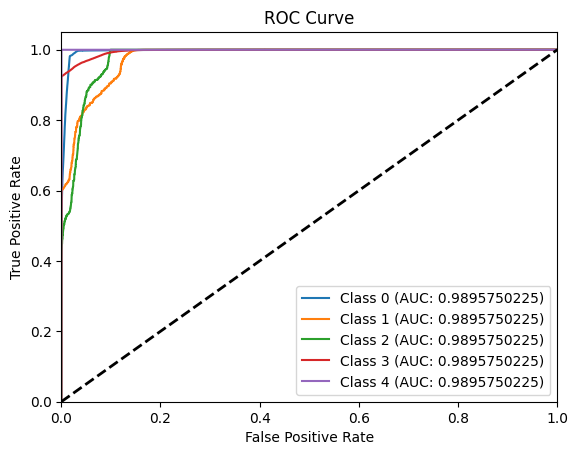

In [17]:
# Import roc_auc_score along with other metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
#####################
# AUC and ROC Curve #
#####################

auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC: {:.10f}".format(auc))

# Import roc_auc_score along with other metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # Add this line to import roc_curve
import matplotlib.pyplot as plt # Import matplotlib
import seaborn as sns  # Import seaborn and assign it to the alias 'sns'

# AUC and ROC Curve
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC: {:.10f}".format(auc))
# Plot ROC curve for each class
fpr = {}
tpr = {}
thresh = {}
for i in range(num_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test[:, i], y_pred[:, i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC: {:.10f})'.format(i, auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

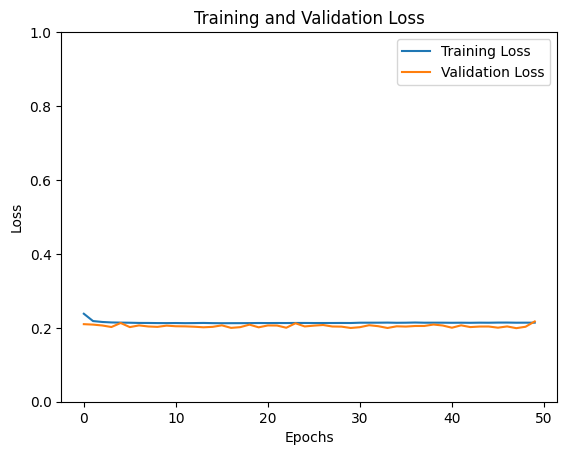

In [19]:
#############################
# Training vs Validation Loss
#############################

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


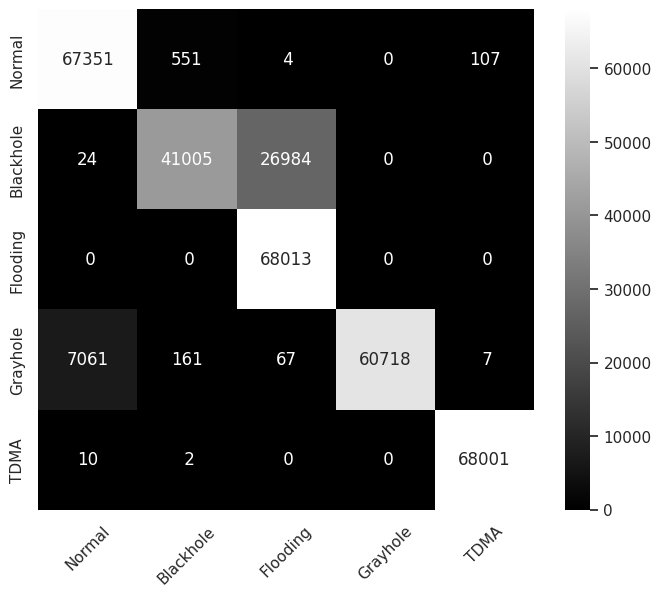

In [28]:
  print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
plt.yticks(ticks=np.arange(5), labels=['Normal','Blackhole','Flooding','Grayhole','TDMA'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='grey',xticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'],
	yticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'])

sns.set(font_scale=1)
plt.show() # Display the heatmap

In [35]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="YlGnBu",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


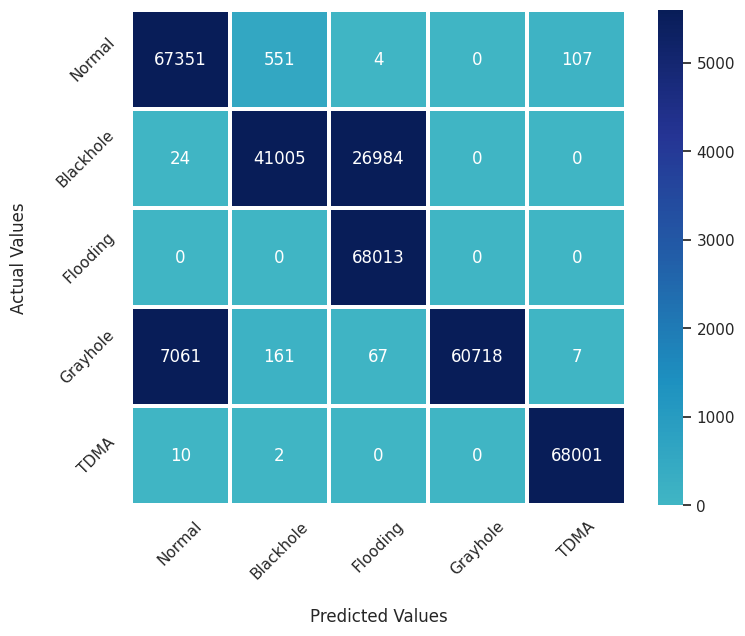

In [36]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)